Первым делом решил попробовать xgboost.
Пробовал Lightgbm, но хорошего результата не смог добиться

In [2]:
import pandas as pd;
import random
import numpy as np;
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
%matplotlib inline

In [25]:
data = pd.read_pickle('data.pik')

Данные можно было не нормировать для xgb, но и хуже от этого не будет

In [17]:
train = data[data['y'] > -1].copy()
test = data[data['y'] == -1].copy()
y = train.pop('y')
del test['y']
X = train
ss = StandardScaler()
ss.fit(X)
X = ss.transform(X)
test = ss.transform(test)
X,y = shuffle(X,y,random_state = 42)

In [19]:
dtrain = xgb.DMatrix(X, label=y)
dtest = xgb.DMatrix(test)

Параметры пробовал подбирать с помощью hyperopt, но это ничего не дало, так как получался огромные std на cv. 
В итоге решил оставить самые "стандартные"

Считалось все на стационарном копьютере, в нем строит Nvidia GeForce GTX 970.
Есть сборка [GPU Accelerated XGBoost](http://dmlc.ml/2016/12/14/GPU-accelerated-xgboost.html), которая ускоряет расчет где-то в 3-6 раз

In [28]:
%%time
param = {'max_depth':4, 'eta':0.0005, 'silent':0,
         'objective':'binary:logistic',
         'subsample':0.8,
         'colsample_bytree':0.8,
         'seed':202,
         #'scale_pos_weight':scale_pos_weight   с этой штуковиной почему-то результат был на мнооого хуже
         'updater':'grow_gpu'
        }
param['eval_metric'] = 'logloss'
trees = 500000
cv = xgb.cv(param, dtrain, metrics=('logloss'), show_stdv=True,
            num_boost_round=trees,nfold=5,early_stopping_rounds = 50)

CPU times: user 20min 8s, sys: 1min 4s, total: 21min 13s
Wall time: 5min 20s


test-logloss-mean     0.380594
test-logloss-std      0.006986
train-logloss-mean    0.363086
train-logloss-std     0.001775
Name: 12012, dtype: float64


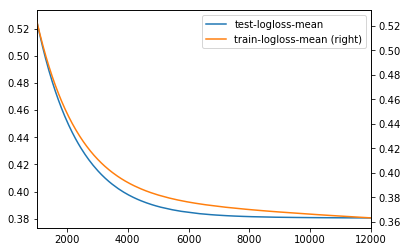

In [29]:
cv[1000:].plot(y=['test-logloss-mean', 'train-logloss-mean'], secondary_y='train-logloss-mean')
print cv.loc[cv['test-logloss-mean'].argmin()]
trees = cv['test-logloss-mean'].argmin()

test-logloss-std 0.006986 говорит нам, что настраивать параметры как-бы смысла нет.

С помощью кросс-валидации подбираем необходимое количество деревьев и запускаем xgb  на всей тестовой выборке.  

In [31]:
%%time
bst = xgb.train(param,dtrain,trees)
a = pd.DataFrame()
a['y'] = bst.predict(dtest)
a.to_csv('xgb.csv', index = False, header = False)

CPU times: user 4min 7s, sys: 14.3 s, total: 4min 21s
Wall time: 1min 5s
